# import lib and function

In [2]:
import kagglehub
import pandas as pd
import os
import numpy as np
from pathlib import Path
from pyspark.sql import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_importance
import shap
from Utils.path_file_loader import target_path
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import optuna


sns.set(style="white")


c:\Users\korph\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

In [3]:
df = pd.read_csv(target_path("DataBase\Cleaned_data.csv"), encoding="utf-8")
df = df.drop(columns=['customerID'])
df = df.rename(columns={'Churn': 'label'})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,label
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Declare Variable

In [4]:
categorical_feature_list = ["gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]

numerical_feature_list = [
    'SeniorCitizen', 
    'tenure', 
    'MonthlyCharges',
    'TotalCharges', 
]

# Module Function

In [40]:
def model_input_preparation(
    df: pd.DataFrame,
    categorical_feature_list: list,
    numerical_feature_list: list,
    feature_one_hot_list: list,
    normal_feature_list: list,
    one_hot: bool,
    scaler: bool,
    test_size: float,
    seed: int,
    selected_feature:bool
):
    if one_hot:
        encoder = OneHotEncoder(sparse_output=False, drop=None)
        encoded = encoder.fit_transform(df[categorical_feature_list])
        df_encoded = pd.DataFrame(
            encoded,
            columns=encoder.get_feature_names_out(categorical_feature_list),
            index=df.index
        )
        df_final = pd.concat([df.drop(categorical_feature_list, axis=1), df_encoded], axis=1)
        if selected_feature:
            df_final = df_final[feature_one_hot_list + ["label"]]
            numerical_feature_list = list(set(numerical_feature_list).intersection(feature_one_hot_list))
    else:
        df_final = df.copy()
        if selected_feature:
            df_final = df_final[normal_feature_list + ["label"]]
            numerical_feature_list = list(set(numerical_feature_list).intersection(normal_feature_list))

    df_final["label"] = df_final["label"].map({"Yes": 1, "No": 0})

    X = df_final.drop(columns=['label'])
    y = df_final["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    if scaler:
        std_scaler = StandardScaler()
        X_train_num = std_scaler.fit_transform(X_train[numerical_feature_list])
        X_test_num = std_scaler.transform(X_test[numerical_feature_list])

        X_train.loc[:, numerical_feature_list] = X_train_num
        X_test.loc[:, numerical_feature_list] = X_test_num

    return X_train, y_train, X_test, y_test


In [81]:
def model_automating_Hyperparamrter(trial, x_train, y_train, x_test, y_test):

    for col in x_train.select_dtypes(include="object").columns:
        x_train[col] = x_train[col].astype("category")
        x_test[col] = x_test[col].astype("category")

    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)

    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        enable_categorical=True
    )
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


# Script

## Linear Baseline

### One-hot + No scaler

In [7]:
X_train, y_train, X_test, y_test = model_input_preparation(df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot = True,
    scaler = False,
    test_size = 0.2,
    seed = 42
)
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8042243521476748, test set 0.8218594748048261


c:\Users\korph\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
X_train.head(5)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2142,0,21,64.85,1336.80,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1623,0,54,97.20,5129.45,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
6074,0,1,23.45,23.45,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1362,0,4,70.20,237.95,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6754,0,0,61.90,0.00,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


### One-hot + scaler

In [9]:
X_train, y_train, X_test, y_test = model_input_preparation(df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42
)

C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2034999928.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2034999928.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2034999928.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value

In [10]:
X_train.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2142,-0.437749,-0.465683,-0.000474,-0.419925,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1623,-0.437749,0.885537,1.074754,1.256017,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
6074,-0.437749,-1.284605,-1.376499,-1.000283,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1362,-0.437749,-1.161766,0.177346,-0.905497,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6754,-0.437749,-1.325551,-0.098524,-1.010646,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [11]:
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8033368832090877, test set 0.8218594748048261


## XGBoost

In [12]:
X_train, y_train, X_test, y_test = model_input_preparation(df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot = False,
    scaler = False,
    test_size = 0.2,
    seed = 42
)

In [13]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2142,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.80
1623,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45
6074,Male,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45
1362,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95
6754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,0.00


In [14]:
y_train.head()

2142    0
1623    0
6074    1
1362    1
6754    0
Name: label, dtype: int64

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: model_automating_Hyperparamrter(trial, X_train, y_train, X_test, y_test), n_trials=500)

print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-09-24 10:10:54,922] A new study created in memory with name: no-name-0cb70e53-fad4-47a6-aa7e-eaf5e66bf36e
c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:10:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-24 10:10:56,199] Trial 0 finished with value: 0.794889992902768 and parameters: {'n_estimators': 255, 'max_depth': 29, 'learning_rate': 0.023612029871195643}. Best is trial 0 with value: 0.794889992902768.
c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:10:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-24 10:10:56,573] Trial 1 finished with value: 0.7863733144073811 and parameters: {'n_estimators': 61, 'max_depth': 14, 'learning_rate': 0.016572

KeyboardInterrupt: 

In [16]:
model = xgb.XGBClassifier(
        n_estimators=289,
        max_depth=4,
        learning_rate=0.013536000803606557,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        enable_categorical=True
    )
model.fit(X_train, y_train)
print(f"XGBoost : training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

XGBoost : training set acc: 0.8159389421370252, test set 0.8168914123491838


c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:11:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### feature importance

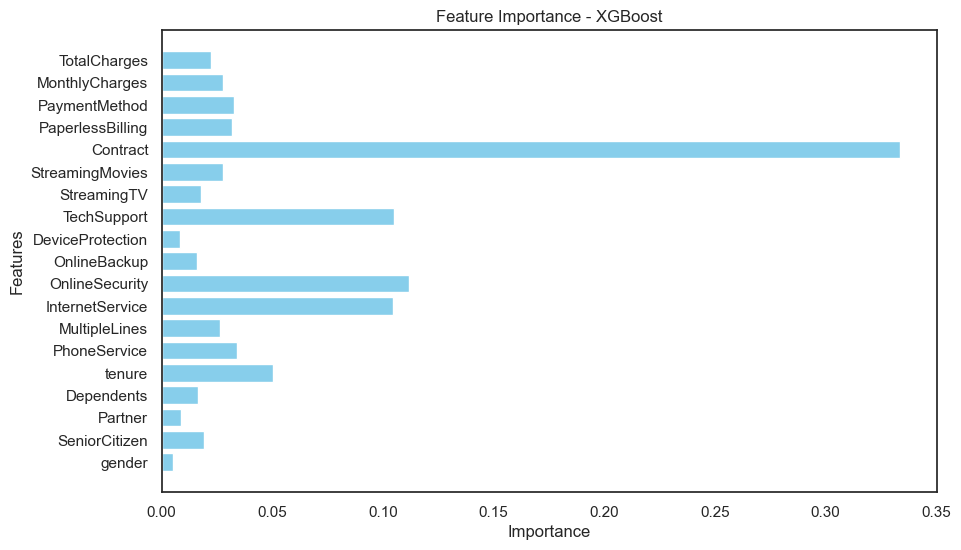

In [17]:
importance = model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, importance, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost")
plt.show()


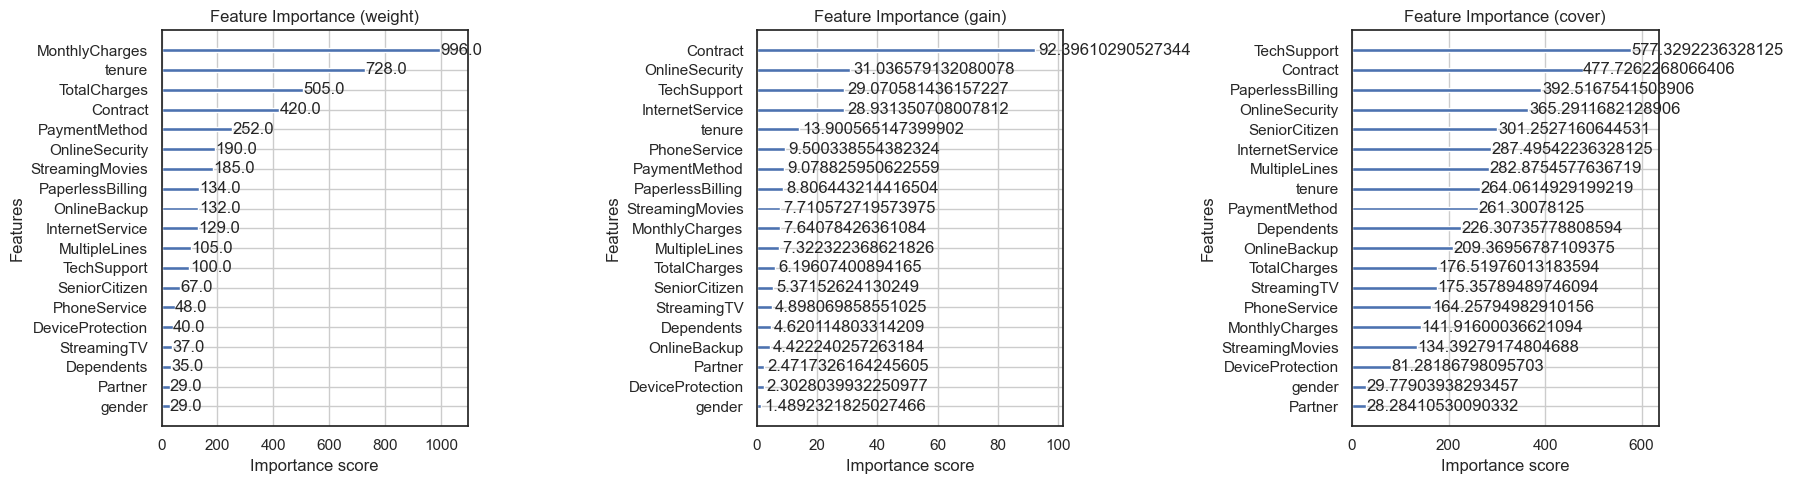

In [18]:
importance_types = ['weight', 'gain', 'cover']

plt.figure(figsize=(18, 5))

for i, imp_type in enumerate(importance_types, 1):
    plt.subplot(1, 3, i)
    plot_importance(model, importance_type=imp_type, ax=plt.gca(), title=f"Feature Importance ({imp_type})")
    
plt.tight_layout()
plt.show()

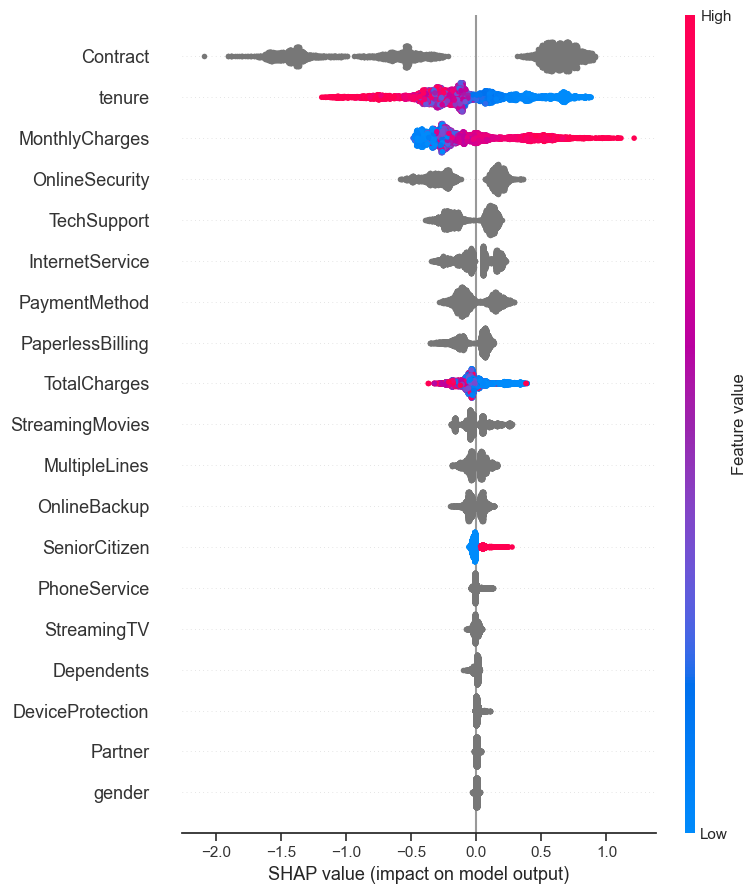

In [20]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


# test selected feature

## no one-hot

In [ ]:
shap_importance = np.abs(shap_values).mean(axis=0)

shap_order = np.argsort(shap_importance)[::-1]

shap_feature_names = X_train.columns[shap_order]

print(shap_feature_names)
print(list(shap_feature_names))


Index(['Contract', 'tenure', 'MonthlyCharges', 'OnlineSecurity', 'TechSupport',
       'InternetService', 'PaymentMethod', 'PaperlessBilling', 'TotalCharges',
       'StreamingMovies', 'MultipleLines', 'OnlineBackup', 'SeniorCitizen',
       'PhoneService', 'StreamingTV', 'Dependents', 'DeviceProtection',
       'Partner', 'gender'],
      dtype='object')
['Contract', 'tenure', 'MonthlyCharges', 'OnlineSecurity', 'TechSupport', 'InternetService', 'PaymentMethod', 'PaperlessBilling', 'TotalCharges', 'StreamingMovies', 'MultipleLines', 'OnlineBackup', 'SeniorCitizen', 'PhoneService', 'StreamingTV', 'Dependents', 'DeviceProtection', 'Partner', 'gender']


## with one-hot

In [53]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = False
)

C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2291779383.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2291779383.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2291779383.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value

In [54]:
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8033368832090877, test set 0.8218594748048261


In [ ]:
X_test

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
185,-0.437749,-1.284605,-1.331629,-0.999687,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2715,-0.437749,0.353238,-1.316672,-0.570322,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3825,-0.437749,0.803645,-1.512772,-0.554746,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1807,-0.437749,-1.284605,0.381756,-0.976907,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
132,-0.437749,1.417836,-0.475768,0.429966,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6366,-0.437749,1.294997,0.114195,0.924311,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
315,-0.437749,0.762699,1.501854,1.502128,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2439,-0.437749,-0.629468,-1.494492,-0.864932,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5002,-0.437749,1.499728,-0.695134,0.297399,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [72]:
feature_importances = pd.Series(
    np.abs(model.coef_).ravel(),
    index=X_test.columns
).sort_values(ascending=False)
print(feature_importances)

tenure                                     1.355812
Contract_Two year                          0.833243
TotalCharges                               0.656542
Contract_Month-to-month                    0.595950
InternetService_DSL                        0.551484
InternetService_Fiber optic                0.505609
MonthlyCharges                             0.399027
PaperlessBilling_No                        0.313091
MultipleLines_No                           0.269195
InternetService_No                         0.245750
OnlineSecurity_No internet service         0.245750
DeviceProtection_No internet service       0.245750
StreamingTV_No internet service            0.245750
OnlineBackup_No internet service           0.245750
TechSupport_No internet service            0.245750
StreamingMovies_No internet service        0.245750
PhoneService_Yes                           0.235812
Dependents_Yes                             0.224018
StreamingMovies_No                         0.218690
OnlineSecuri

In [73]:
feature_importances = feature_importances[feature_importances > 0.05]
print(feature_importances)
print(feature_importances.index)

tenure                                     1.355812
Contract_Two year                          0.833243
TotalCharges                               0.656542
Contract_Month-to-month                    0.595950
InternetService_DSL                        0.551484
InternetService_Fiber optic                0.505609
MonthlyCharges                             0.399027
PaperlessBilling_No                        0.313091
MultipleLines_No                           0.269195
InternetService_No                         0.245750
OnlineSecurity_No internet service         0.245750
DeviceProtection_No internet service       0.245750
StreamingTV_No internet service            0.245750
OnlineBackup_No internet service           0.245750
TechSupport_No internet service            0.245750
StreamingMovies_No internet service        0.245750
PhoneService_Yes                           0.235812
Dependents_Yes                             0.224018
StreamingMovies_No                         0.218690
OnlineSecuri

# Selected feature

In [74]:
one_hot_feature = ['tenure',
 'Contract_Two year',
 'TotalCharges',
 'Contract_Month-to-month',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'MonthlyCharges',
 'PaperlessBilling_No',
 'MultipleLines_No',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'DeviceProtection_No internet service',
 'StreamingTV_No internet service',
 'OnlineBackup_No internet service',
 'TechSupport_No internet service',
 'StreamingMovies_No internet service',
 'PhoneService_Yes',
 'Dependents_Yes',
 'StreamingMovies_No',
 'OnlineSecurity_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'TechSupport_Yes',
 'StreamingMovies_Yes',
 'Partner_No',
 'OnlineSecurity_No',
 'gender_Male',
 'StreamingTV_No',
 'PaymentMethod_Mailed check',
 'TechSupport_No',
 'PaymentMethod_Bank transfer (automatic)',
 'StreamingTV_Yes',
 'gender_Female',
 'Partner_Yes',
 'OnlineBackup_Yes', 
 'Dependents_No',
'SeniorCitizen', 
'PhoneService_No', 
'MultipleLines_No phone service',
'Contract_One year']

In [ ]:
normal_selected_feature = [
    'Contract', 
    'tenure', 
    'MonthlyCharges', 
    'OnlineSecurity', 
    'TechSupport', 
    'InternetService', 
    'PaymentMethod', 
    'PaperlessBilling', 
    'TotalCharges', 
    'StreamingMovies', 
    'MultipleLines', 
    'OnlineBackup', 
    'SeniorCitizen'
]

# evaluation test

## linear selected feature test

In [75]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = True
)

C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2291779383.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2291779383.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2291779383.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value

In [76]:
X_train

,tenure,Contract_Two year,TotalCharges,Contract_Month-to-month,InternetService_DSL,InternetService_Fiber optic,MonthlyCharges,PaperlessBilling_No,MultipleLines_No,InternetService_No,...,PaymentMethod_Bank transfer (automatic),StreamingTV_Yes,gender_Female,Partner_Yes,OnlineBackup_Yes,Dependents_No,SeniorCitizen,PhoneService_No,MultipleLines_No phone service,Contract_One year
2142,-0.465683,0.0,-0.419925,0.0,1.0,0.0,-0.000474,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.437749,0.0,0.0,1.0
1623,0.885537,1.0,1.256017,0.0,0.0,1.0,1.074754,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,-0.437749,0.0,0.0,0.0
6074,-1.284605,0.0,-1.000283,1.0,1.0,0.0,-1.376499,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,-0.437749,1.0,1.0,0.0
1362,-1.161766,0.0,-0.905497,1.0,0.0,1.0,0.177346,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.437749,0.0,0.0,0.0
6754,-1.325551,1.0,-1.010646,0.0,1.0,0.0,-0.098524,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,-0.437749,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-1.284605,0.0,-0.968666,1.0,0.0,1.0,1.001632,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,-0.437749,0.0,0.0,0.0
5191,-0.383791,1.0,-0.039235,0.0,1.0,0.0,0.872006,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,-0.437749,0.0,0.0,0.0
5226,-0.834198,0.0,-0.875405,1.0,0.0,0.0,-1.452945,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.437749,0.0,0.0,0.0
5390,-0.834198,0.0,-0.480309,1.0,0.0,1.0,1.149538,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,2.284413,0.0,0.0,0.0


In [77]:
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8036918707845225, test set 0.8211497515968772


In [78]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = False
)

C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2291779383.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2291779383.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
C:\Users\korph\AppData\Local\Temp\ipykernel_29140\2291779383.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value

In [79]:
X_train

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2142,-0.437749,-0.465683,-0.000474,-0.419925,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1623,-0.437749,0.885537,1.074754,1.256017,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
6074,-0.437749,-1.284605,-1.376499,-1.000283,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1362,-0.437749,-1.161766,0.177346,-0.905497,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6754,-0.437749,-1.325551,-0.098524,-1.010646,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.437749,-1.284605,1.001632,-0.968666,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5191,-0.437749,-0.383791,0.872006,-0.039235,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5226,-0.437749,-0.834198,-1.452945,-0.875405,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5390,2.284413,-0.834198,1.149538,-0.480309,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [80]:
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8033368832090877, test set 0.8218594748048261


## XGBoost selected feature test

In [82]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = False,
    scaler = False,
    test_size = 0.2,
    seed = 42,
    selected_feature = True
)

In [83]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: model_automating_Hyperparamrter(trial, X_train, y_train, X_test, y_test), n_trials=500)

print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-09-24 11:13:41,364] A new study created in memory with name: no-name-4e8d4ff7-f3b0-421a-8b4d-f2921d6dd445
c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:13:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-24 11:13:42,192] Trial 0 finished with value: 0.7920511000709723 and parameters: {'n_estimators': 192, 'max_depth': 30, 'learning_rate': 0.04936627958129844}. Best is trial 0 with value: 0.7920511000709723.
c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:13:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-24 11:13:42,661] Trial 1 finished with value: 0.7927608232789212 and parameters: {'n_estimators': 108, 'max_depth': 17, 'learning_rate': 0.0231

Best parameters: {'n_estimators': 77, 'max_depth': 4, 'learning_rate': 0.05609349717873185}
Best accuracy: 0.8168914123491838
